# Supervised Multi-Label Toxic Comment Classification: Comparative Analysis of Contextual (DistilBERT) and Static Word Embeddings (FastText-TextCNN)

## 1. Project Setup and Environment

### 1.1 Dependencies and Library Imports

In [1]:
# This cell is only for installing a specific version of 'protobuf' to avoid package conflicts
!pip install protobuf==3.20.3 --no-dependencies --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


In [2]:
# A utility function to check for and install required packages if they are missing.
import importlib, subprocess, sys
def ensure_package(pkg_name, import_name=None):
    """Checks for and installs missing packages."""
    try:
        importlib.import_module(import_name or pkg_name)
    except Exception:
        # Executes pip install command
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

# Installing required libraries
ensure_package('transformers')
ensure_package('scikit-learn')
ensure_package('torch')

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import re, zipfile, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and Scikit-learn Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

# Hugging Face Imports
from transformers import DistilBertTokenizerFast, DistilBertModel, get_linear_schedule_with_warmup

warnings.filterwarnings('ignore')

2025-12-17 10:37:27.542297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765967847.704835      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765967847.753747      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1.2 Configuration (Device and Random Seeds Utility)

In [4]:
# Determining the device (GPU/CUDA or CPU) for model training.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# --- Random Seed Utility Function ---
def set_seed(seed):
    """Sets the random seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # For deterministic behavior on CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set a common random seed for the entire project
SEED = 42 
set_seed(SEED)
print(f"Random seed set to: {SEED}")

Using device: cuda
Random seed set to: 42


## 2. Data Loading and Initial Exploration

### 2.1 Load Raw Data and Filter Test Set

In [5]:
# Define the data directory and the target label columns
KAGGLE_DATA_DIR = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/'
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
NUM_LABELS = len(label_cols)

# Function to load data safely
def load_csv(filename, data_dir=KAGGLE_DATA_DIR):
    """Loads a CSV file from the specified directory."""
    try:
        path = os.path.join(data_dir, filename)
        return pd.read_csv(path)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return pd.DataFrame()

# Load all necessary dataframes
train_df = load_csv('train.csv')
test_df = load_csv('test.csv')
test_labels_df = load_csv('test_labels.csv')

# Merge test data with labels and filter out non-target rows (where all labels are -1)
merged_test_df = pd.merge(test_df, test_labels_df, on='id', how='inner')
valid_test_df = merged_test_df[(merged_test_df[label_cols] != -1).any(axis=1)].copy()

### 2.2 Initial Data Inspection and Target Distribution

[INFO] Initial Train Shape: (159571, 8)
[INFO] Filtered Valid Test Shape: (63978, 8)

Training Data Head:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Total comments: 159571
Toxic comments (at least one label)

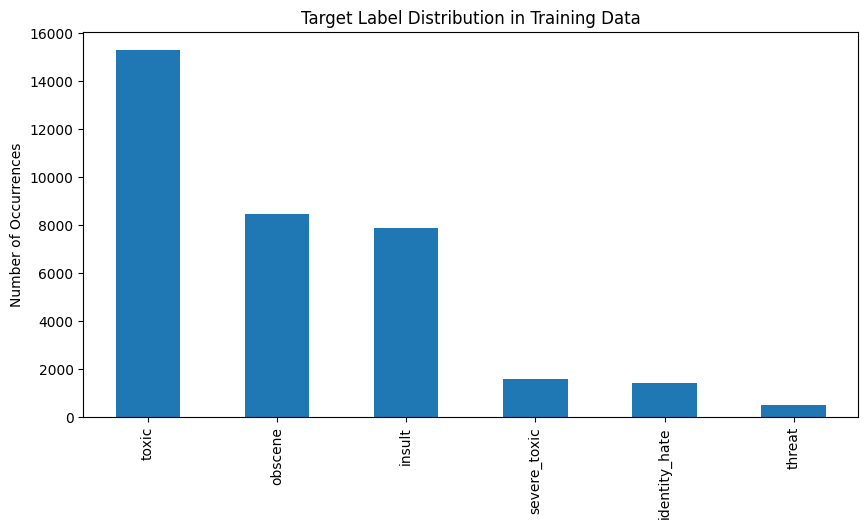

In [6]:
print(f"[INFO] Initial Train Shape: {train_df.shape}")
print(f"[INFO] Filtered Valid Test Shape: {valid_test_df.shape}")

# Show head of the training data
print("\nTraining Data Head:")
print(train_df.head())

# Calculate the count of toxic comments (for inspection)
row_sums = train_df[label_cols].sum(axis=1)
print(f"\nTotal comments: {len(train_df)}")
print(f"Toxic comments (at least one label): {len(row_sums[row_sums > 0])}")

# Plotting the count of each type of toxicity
plt.figure(figsize=(10, 5))
train_df[label_cols].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Target Label Distribution in Training Data')
plt.ylabel('Number of Occurrences')
plt.show()

### 2.3 Define Global Label Columns

In [7]:
# Confirming the labels used for multi-label classification
print("Labels defined for classification:")
print(label_cols)

Labels defined for classification:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## 3. Data Preprocessing and Splitting

### 3.1 Text Cleaning Function Definition

In [8]:
emoji_pattern = re.compile(
    "[" 
    u"\\U0001F600-\\U0001F64F" # Emoticons
    u"\\U0001F300-\\U0001F5FF" # Symbols & Pictographs
    u"\\U0001F680-\\U0001F6FF" # Transport & Map Symbols
    u"\\U0001F1E0-\\U0001F1FF" # Regional Indicators (Flags)
    u"\\U00002700-\\U000027BF" # Dingbats/Miscellaneous Symbols
    u"\\U0001F900-\\U0001F9FF" # Supplemental Symbols and Pictographs
    "]+", flags=re.UNICODE)

def bert_minimal_clean(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    # Remove URLs (using the broader pattern)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # Remove mentions (added for robustness, though not in your last snippet)
    text = re.sub(r'@\w+', ' ', text) 
    # Remove HTML Tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove Emojis
    text = emoji_pattern.sub(" ", text)
    # Normalize and strip whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Duplicate Handling Function
def drop_dup_keep_if_labels_identical(df, text_col, label_cols):
    if df.empty:
        return df
    groups = df.groupby(text_col)
    keep_idx = []
    for txt, idxs in groups.groups.items():
        subset = df.loc[idxs]
        # Keep only one if all labels across the duplicates are identical (nunique max is 1)
        if (subset[label_cols].nunique().max() == 1):
            keep_idx.append(subset.index[0])
        else:
            # Keep all if labels show variation (different labels for same text)
            keep_idx.extend(subset.index.tolist())
    return df.loc[sorted(keep_idx)].reset_index(drop=True)

### 3.2 Applying Cleaning and Final Train/Validation Split

In [9]:
# 1. Apply cleaning on the training data copy
train_df_clean = train_df.copy()
train_df_clean['comment_text_bert'] = train_df_clean['comment_text'].apply(bert_minimal_clean)

# 2. Remove rows where the cleaned text is empty or just whitespace
train_df_clean = train_df_clean[train_df_clean['comment_text_bert'].str.strip() != ""] 

# 3. Remove label-identical duplicates
train_df_clean = drop_dup_keep_if_labels_identical(train_df_clean, 'comment_text_bert', label_cols)

print(f"[INFO] Final Train Shape after cleaning and duplicate removal: {train_df_clean.shape}")

# --- Test Data Cleaning ---
test_df_clean = valid_test_df.copy()
test_df_clean['comment_text_bert'] = test_df_clean['comment_text'].apply(bert_minimal_clean)

# Remove empty/whitespace-only rows
test_df_clean = test_df_clean[test_df_clean['comment_text_bert'].str.strip() != ""]

# Remove duplicate comments
test_df_clean = test_df_clean.drop_duplicates(subset='comment_text_bert').reset_index(drop=True)

print(f"[INFO] Final Test Shape after cleaning: {test_df_clean.shape}")

# --- Train / Validation Split ---
X = train_df_clean['comment_text_bert'].values
Y = train_df_clean[label_cols].values

from sklearn.model_selection import train_test_split
train_texts, val_texts, train_y, val_y = train_test_split(
    X,
    Y,
    test_size=0.10,
    random_state=42,
    shuffle=True
)

print(f"\n[INFO] Final Training Samples: {len(train_texts)}")
print(f"[INFO] Final Validation Samples: {len(val_texts)}")


[INFO] Final Train Shape after cleaning and duplicate removal: (159330, 9)
[INFO] Final Test Shape after cleaning: (63927, 9)

[INFO] Final Training Samples: 143397
[INFO] Final Validation Samples: 15933


## 4. Loss Function Definition

### 4.1 Focal Loss Implementation

In [31]:
# Implementing Focal Loss, which is suitable for highly imbalanced datasets like toxic comment classification. 
# It focuses training on hard-to-classify examples by down-weighting the loss from well-classified ones.
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha # Weighting factor (balances importance of positive vs. negative classes)
        self.gamma = gamma # Focusing factor (increases focus on hard examples)
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute Binary Cross-Entropy Loss (BCE)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Probability of correct classification (pt)
        pt = torch.exp(-BCE_loss) 
        
        # Focusing term: (1 - pt)^gamma (down-weights easy examples)
        focal_term = (1 - pt) ** self.gamma
        
        # Alpha factor: alpha (for positive class) or (1-alpha) (for negative class)
        alpha_factor = targets * self.alpha + (1 - targets) * (1 - self.alpha)
        
        # Final Focal Loss calculation
        Focal_Loss = alpha_factor * focal_term * BCE_loss
        
        if self.reduction == 'mean':
            return Focal_Loss.mean()
        elif self.reduction == 'sum':
            return Focal_Loss.sum()
        else:
            return Focal_Loss

## Model 1: TextCNN with Word Embeddings (FastText-Static Representation)

### 5. Data Preparation and Embedding Setup for TextCNN

#### 5.1 Vocabulary Creation and Padding

In [32]:
# Data preprocessing for the CNN model: converting words to indices, vocabulary creation, and padding.
import numpy as np
import torch
from collections import Counter
from itertools import chain
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# --- Hyperparameters for CNN Data ---
MAX_LEN_CNN = 100 # Maximum sequence length for the CNN
BATCH_SIZE_CNN = 64
VOCAB_SIZE = 50000
EMBEDDING_DIM = 300 # FastText embedding dimension

# 1. Build Vocabulary (Word-to-Index mapping)
# Creating vocabulary by counting word frequencies from the training data.
word_counts = Counter(chain.from_iterable(text.split() for text in train_texts))
most_common_words = [word for word, count in word_counts.most_common(VOCAB_SIZE - 1)]
word_to_index = {word: i + 1 for i, word in enumerate(most_common_words)}
word_to_index['<PAD>'] = 0 # Padding token
word_to_index['<UNK>'] = len(word_to_index) # Unknown word token
FINAL_VOCAB_SIZE = len(word_to_index)
print(f"[INFO] Final Vocabulary Size: {FINAL_VOCAB_SIZE}")

# 2. Convert text to sequences of indices
def text_to_sequence(texts, word_to_index):
    """Converts text into sequences of integer indices."""
    sequences = []
    for text in texts:
        seq = [word_to_index.get(word, word_to_index['<UNK>']) for word in text.split()]
        sequences.append(seq)
    return sequences

train_sequences = text_to_sequence(train_texts, word_to_index)
val_sequences = text_to_sequence(val_texts, word_to_index)
test_sequences = text_to_sequence(test_df_clean['comment_text_bert'].tolist(), word_to_index)

# 3. Padding
def pad_sequences(sequences, maxlen, padding='post', truncating='post'):
    """Applies padding to sequences."""
    padded = np.zeros((len(sequences), maxlen), dtype=np.int64)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            seq = seq[:maxlen] if truncating == 'post' else seq[-maxlen:]
        if padding == 'post':
            padded[i, :len(seq)] = seq
        else:
            padded[i, (maxlen - len(seq)):] = seq
    return torch.tensor(padded, dtype=torch.long)

train_input = pad_sequences(train_sequences, MAX_LEN_CNN)
val_input = pad_sequences(val_sequences, MAX_LEN_CNN)
test_input = pad_sequences(test_sequences, MAX_LEN_CNN)

# 4. Dataset Class (Specific Dataset class for CNN)
class JigsawDatasetCNN(Dataset):
    def __init__(self, input_data, labels):
        self.input_data = input_data
        self.labels = labels

    def __getitem__(self, idx):
        item = {'input_data': self.input_data[idx]}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# 5. DataLoader Preparation
train_dataset_cnn = JigsawDatasetCNN(train_input, train_y)
val_dataset_cnn = JigsawDatasetCNN(val_input, val_y)
test_dataset_cnn = JigsawDatasetCNN(test_input, test_df_clean[label_cols].values)

train_dataloader_cnn = DataLoader(train_dataset_cnn, sampler=RandomSampler(train_dataset_cnn), batch_size=BATCH_SIZE_CNN)
val_dataloader_cnn = DataLoader(val_dataset_cnn, sampler=SequentialSampler(val_dataset_cnn), batch_size=BATCH_SIZE_CNN)
test_dataloader_cnn = DataLoader(test_dataset_cnn, sampler=SequentialSampler(test_dataset_cnn), batch_size=BATCH_SIZE_CNN)

[INFO] Final Vocabulary Size: 50001


#### 5.2 Loading FastText Vectors

In [33]:
FASTTEXT_PATH = '/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

def load_embeddings(path):
    embeddings_index = {}
    try:
        # Using 'errors=ignore' to handle large files robustly.
        with open(path, encoding='utf-8', errors='ignore') as f:
            for i, line in enumerate(f):
                if i == 0 and len(line.split(' ')) == 2: # Skip header line
                    continue 
                values = line.rstrip().split(' ')
                if len(values) == EMBEDDING_DIM + 1:
                    word = values[0]
                    vector = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = vector
    except FileNotFoundError:
        print(f"[ERROR] FastText file not found at {path}.")
        return {}
    print(f"[INFO] Loaded {len(embeddings_index)} word vectors.")
    return embeddings_index

# Load vectors
embeddings_index = load_embeddings(FASTTEXT_PATH)

# IMPROVED: Case-insensitive embedding lookup
def get_best_embedding(word, embeddings_index):
    # 1. Exact match (original case)
    if word in embeddings_index:
        return embeddings_index[word]
    
    # 2. Lowercase match (most common fix)
    if word.lower() in embeddings_index:
        return embeddings_index[word.lower()]
    
    # 3. Title case match
    if word.title() in embeddings_index:
        return embeddings_index[word.title()]
    
    return None

# Create Embedding Matrix with improved matching
embedding_matrix = np.zeros((FINAL_VOCAB_SIZE, EMBEDDING_DIM))
hits = 0
misses = 0
case_matched_words = 0

for word, i in word_to_index.items():
    if i == 0: continue # Skip PAD token (index 0)
    
    # Use improved embedding lookup
    embedding_vector = get_best_embedding(word, embeddings_index)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
        
        # Track words found through case variations (not exact match)
        if word not in embeddings_index:
            case_matched_words += 1
    else:
        # Random initialization for OOV words
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM, ))
        misses += 1

print(f"\n=== FASTTEXT EMBEDDING COVERAGE ===")
print(f"Total Vocabulary: {FINAL_VOCAB_SIZE:,}")
print(f"Words with FastText embeddings: {hits:,}")
print(f"Words with random embeddings: {misses:,}")
print(f"Overall Coverage: {(hits/FINAL_VOCAB_SIZE)*100:.1f}%")

if case_matched_words > 0:
    print(f"Extra words found via case-matching: {case_matched_words:,}")
    print(f"Case-matching improved coverage by: +{(case_matched_words/FINAL_VOCAB_SIZE)*100:.1f}%")

# Show examples of case-matched words
print(f"\n--- Examples of Case-Matched Words ---")
examples_shown = 0
for word, i in word_to_index.items():
    if i == 0: continue
    if word not in embeddings_index and get_best_embedding(word, embeddings_index) is not None:
        # Find which case variation worked
        if word.lower() in embeddings_index:
            print(f"  '{word}' → found as '{word.lower()}'")
        elif word.title() in embeddings_index:
            print(f"  '{word}' → found as '{word.title()}'")
        examples_shown += 1
        if examples_shown >= 8:
            break

# Memory cleanup
del embeddings_index

[INFO] Loaded 2000000 word vectors.

=== FASTTEXT EMBEDDING COVERAGE ===
Total Vocabulary: 50,001
Words with FastText embeddings: 32,362
Words with random embeddings: 17,638
Overall Coverage: 64.7%
Extra words found via case-matching: 605
Case-matching improved coverage by: +1.2%

--- Examples of Case-Matched Words ---
  'veggietales' → found as 'Veggietales'
  'ullmann' → found as 'Ullmann'
  '"the' → found as '"The'
  '“the' → found as '“The'
  'commons.' → found as 'Commons.'
  'gamaliel' → found as 'Gamaliel'
  'latinus' → found as 'Latinus'
  'yugoslav' → found as 'Yugoslav'


### 6. Model 1 Architecture and Training Execution

#### 6.1 TextCNN Architecture Definition

In [34]:
# Definition of the TextCNN model in PyTorch. It utilizes multiple kernel sizes and global max-pooling.
import torch.nn.functional as F

class TextCNNMultiLabel(nn.Module):
    def __init__(self, embedding_matrix, num_labels, num_filters=128, kernel_sizes=[3, 4, 5]):
        super().__init__()
        
        # Load pre-trained embedding matrix. freeze=False means embeddings will be fine-tuned.
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32), 
            freeze=False,
            padding_idx=0
        )
        
        embedding_dim = embedding_matrix.shape[1]
        
        # Create convolutional layers with multiple kernel sizes (filters)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=k) for k in kernel_sizes
        ])
        
        self.dropout = nn.Dropout(0.5)
        # Final fully-connected layer
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_labels)
        self.loss_fn = FocalLoss(alpha=0.25, gamma=2) # Using Focal Loss

    def forward(self, input_data, labels=None):
        embedded = self.embedding(input_data)
        
        # Permute input format for Conv1d: (Batch, Dim, Len)
        embedded = embedded.permute(0, 2, 1) 

        # Convolution and ReLU activation
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        
        # Global Max Pooling (taking the maximum value from each filter)
        pooled = [F.max_pool1d(c, c.shape[-1]).squeeze(-1) for c in conved] 
        
        # Concatenate pooled outputs and apply Dropout
        cat = self.dropout(torch.cat(pooled, dim=-1))
        
        # Classification
        logits = self.fc(cat)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            
        return loss, torch.sigmoid(logits)

# --- Initialize Model ---
model_cnn = TextCNNMultiLabel(
    embedding_matrix=embedding_matrix,
    num_labels=NUM_LABELS
).to(device)

print("[INFO] FastText CNN Model initialized.")

[INFO] FastText CNN Model initialized.


#### 6.2 Training Loop Execution

In [ ]:
# ---- Hyperparameters for CNN ----
LEARNING_RATE_CNN = 1e-3 
EPOCHS_CNN = 2 

# ---- Optimizer ----
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE_CNN)  

# ---- Training Function ----
def train_fn_cnn(model, train_loader, val_loader, optimizer, epochs):
    # Initialize variable to track the best validation loss
    best_val_loss = float('inf') 

    for epoch in range(epochs):
        print(f"\n======== Epoch {epoch+1} / {epochs} ========")
        
        model.train()
        total_loss = 0
        
        # --- Training Loop ---
        for step, batch in enumerate(train_loader):
            # Move data to the defined device (GPU/CPU)
            input_data = batch['input_data'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            loss, _ = model(input_data, labels)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            if step % 500 == 0 and step > 0:
                print(f"  Batch {step} | Train Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)
        print(f"\nAVERAGE TRAIN LOSS: {avg_train_loss:.4f}")

        # --- Validation Loop ---
        model.eval()
        total_val_loss = 0
        print("Running Validation...")
        with torch.no_grad():
            for batch in val_loader:
                input_data = batch['input_data'].to(device)
                labels = batch['labels'].to(device)
                
                loss, _ = model(input_data, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"VALIDATION LOSS: {avg_val_loss:.4f}")
        
        # Early Stopping and Model Saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save the model only if validation loss improves
            torch.save(model.state_dict(), "best_cnn_model.bin")
            print(f"*** CNN Model Saved: Validation Loss improved to {best_val_loss:.4f} ***")
        else:
            print("Validation Loss did not improve.")

# Run Training
train_fn_cnn(model_cnn, train_dataloader_cnn, val_dataloader_cnn, optimizer_cnn, EPOCHS_CNN)


======== Epoch 1 / 2 ========
  Batch 500 | Train Loss: 0.0129
  Batch 1000 | Train Loss: 0.0103
  Batch 1500 | Train Loss: 0.0093
  Batch 2000 | Train Loss: 0.0095

AVERAGE TRAIN LOSS: 0.0074
Running Validation...
VALIDATION LOSS: 0.0057
*** CNN Model Saved: Validation Loss improved to 0.0057 ***

======== Epoch 2 / 2 ========
  Batch 500 | Train Loss: 0.0029
  Batch 1000 | Train Loss: 0.0058
  Batch 1500 | Train Loss: 0.0080
  Batch 2000 | Train Loss: 0.0027

AVERAGE TRAIN LOSS: 0.0056
Running Validation...
VALIDATION LOSS: 0.0060
Validation Loss did not improve.


### 7. Model 1 Evaluation and Visualizations

#### 7.1 Load Best CNN Model and Verification

In [36]:
import sklearn
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve 
from tqdm import tqdm

best_cnn_model = TextCNNMultiLabel(
    embedding_matrix=embedding_matrix, 
    num_labels=NUM_LABELS
).to(device)
# Load the Best Trained Model
try:
    best_cnn_model.load_state_dict(torch.load("best_cnn_model.bin"))
    best_cnn_model.to(device)
    best_cnn_model.eval()
    print("Successfully loaded weights from best_cnn_model.bin")
    
    # Model verification
    total_params = sum(p.numel() for p in best_cnn_model.parameters())
    print(f"Model Parameters: {total_params:,}")
    print(f"Model Device: {next(best_cnn_model.parameters()).device}")
    
except FileNotFoundError:
    print("ERROR: best_cnn_model.bin not found. Please run training first.")
except Exception as e:
    print(f"ERROR: Model loading failed: {e}")

Successfully loaded weights from best_cnn_model.bin
Model Parameters: 15,463,794
Model Device: cuda:0


#### 7.2 Enhanced Prediction Generation

In [37]:
# Improved CNN-specific prediction function with progress tracking
def get_predictions_cnn(model, loader, desc="Predicting"):
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"Generating {desc} predictions...")
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=desc, leave=True, unit="batch"):
            try:
                input_data = batch['input_data'].to(device) 
                labels = batch['labels'].to(device)

                _, preds = model(input_data)
                
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
                
            except Exception as e:
                print(f"Prediction error: {e}")
                continue
            
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    print(f"{desc} completed: {all_preds.shape[0]} samples")
    return all_preds, all_labels

# Generate predictions for validation and test sets

val_preds_cnn, val_labels_cnn = get_predictions_cnn(
    best_cnn_model, val_dataloader_cnn, "Validation"
)

test_preds_cnn, test_labels_cnn = get_predictions_cnn(
    best_cnn_model, test_dataloader_cnn, "Test"
)

# Data quality check
print("Prediction Shapes:")
print(f"Validation: {val_preds_cnn.shape} (preds), {val_labels_cnn.shape} (labels)")
print(f"Test: {test_preds_cnn.shape} (preds), {test_labels_cnn.shape} (labels)")

# Check for NaN values
if np.isnan(val_preds_cnn).any() or np.isnan(test_preds_cnn).any():
    print("Warning: NaN values detected in predictions")
else:
    print("No NaN values in predictions")

Generating Validation predictions...


Validation: 100%|██████████| 249/249 [00:00<00:00, 395.55batch/s]


Validation completed: 15933 samples
Generating Test predictions...


Test: 100%|██████████| 999/999 [00:02<00:00, 396.82batch/s]


Test completed: 63927 samples
Prediction Shapes:
Validation: (15933, 6) (preds), (15933, 6) (labels)
Test: (63927, 6) (preds), (63927, 6) (labels)
No NaN values in predictions


#### 7.3 Threshold Optimization and Analysis

In [38]:
def optimize_thresholds_fine(val_preds, val_labels, label_cols, threshold_range=(0.1, 0.9), step=0.02):
    best_thresholds = {}
    threshold_metrics = {}
    
    print(f"Fine-grained threshold optimization ({threshold_range[0]}-{threshold_range[1]}, step={step})")
    
    for i, col in enumerate(tqdm(label_cols, desc="Optimizing thresholds")):
        best_f1 = 0
        best_thresh = 0.5
        best_precision = 0
        best_recall = 0
        
        for thresh in np.arange(threshold_range[0], threshold_range[1] + step, step):
            hard_preds = (val_preds[:, i] >= thresh).astype(int)
            f1 = f1_score(val_labels[:, i], hard_preds, zero_division=0)
            precision = sklearn.metrics.precision_score(val_labels[:, i], hard_preds, zero_division=0)
            recall = sklearn.metrics.recall_score(val_labels[:, i], hard_preds, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
                best_precision = precision
                best_recall = recall
        
        best_thresholds[col] = best_thresh
        threshold_metrics[col] = {
            'best_threshold': best_thresh,
            'best_f1': best_f1,
            'precision': best_precision,
            'recall': best_recall
        }
    
    return best_thresholds, threshold_metrics

# Perform fine-grained threshold optimization
best_thresholds_cnn, threshold_metrics = optimize_thresholds_fine(
    val_preds_cnn, val_labels_cnn, label_cols, threshold_range=(0.01, 0.95), step=0.01
)

print("OPTIMIZED THRESHOLDS FOR CNN MODEL")

# Display optimized thresholds
print("Label           Threshold  F1-Score  Precision  Recall")
print("------------------------------------------------------")
for col in label_cols:
    metrics = threshold_metrics[col]
    print(f"{col:<15} {metrics['best_threshold']:<10.2f} {metrics['best_f1']:<10.4f} "
          f"{metrics['precision']:<10.4f} {metrics['recall']:<10.4f}")

# Apply optimized thresholds to test set
test_preds_binary_cnn = np.zeros_like(test_preds_cnn)
for i, col in enumerate(label_cols):
    thresh = best_thresholds_cnn[col]
    test_preds_binary_cnn[:, i] = (test_preds_cnn[:, i] >= thresh).astype(int)

Fine-grained threshold optimization (0.01-0.95, step=0.01)


Optimizing thresholds: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

OPTIMIZED THRESHOLDS FOR CNN MODEL
Label           Threshold  F1-Score  Precision  Recall
------------------------------------------------------
toxic           0.35       0.7681     0.7858     0.7511    
severe_toxic    0.31       0.4883     0.4052     0.6144    
obscene         0.30       0.7613     0.7617     0.7608    
threat          0.23       0.3333     0.3091     0.3617    
insult          0.33       0.7065     0.6747     0.7414    
identity_hate   0.30       0.4981     0.6132     0.4194    


#### 7.4 Comprehensive Model Evaluation

In [39]:
# 1. AUC-ROC Scores
auc_scores_cnn = {}
for i, col in enumerate(label_cols):
    auc_scores_cnn[col] = roc_auc_score(test_labels_cnn[:, i], test_preds_cnn[:, i])

macro_auc_cnn = np.mean(list(auc_scores_cnn.values()))
micro_auc_cnn = roc_auc_score(test_labels_cnn.ravel(), test_preds_cnn.ravel())

print("ROC-AUC SCORES:")
print(f"Macro Average: {macro_auc_cnn:.4f}")
print(f"Micro Average: {micro_auc_cnn:.4f}")
print("Per-class AUC:")
for col in label_cols:
    print(f"{col:<15}: {auc_scores_cnn[col]:.4f}")

# 2. F1 Scores with optimized thresholds
f1_scores_macro = f1_score(test_labels_cnn, test_preds_binary_cnn, average='macro', zero_division=0)
f1_scores_micro = f1_score(test_labels_cnn, test_preds_binary_cnn, average='micro', zero_division=0)
f1_scores_per_class = f1_score(test_labels_cnn, test_preds_binary_cnn, average=None, zero_division=0)

print("F1 SCORES (with optimized thresholds):")
print(f"Macro F1: {f1_scores_macro:.4f}")
print(f"Micro F1: {f1_scores_micro:.4f}")
print("Per-class F1:")
for i, col in enumerate(label_cols):
    print(f"{col:<15}: {f1_scores_per_class[i]:.4f}")

# 3. Detailed classification report
print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(test_labels_cnn, test_preds_binary_cnn, 
                          target_names=label_cols, zero_division=0, digits=4))

ROC-AUC SCORES:
Macro Average: 0.9555
Micro Average: 0.9634
Per-class AUC:
toxic          : 0.9435
severe_toxic   : 0.9724
obscene        : 0.9499
threat         : 0.9671
insult         : 0.9510
identity_hate  : 0.9491
F1 SCORES (with optimized thresholds):
Macro F1: 0.4764
Micro F1: 0.5846
Per-class F1:
toxic          : 0.6190
severe_toxic   : 0.3001
obscene        : 0.6120
threat         : 0.3233
insult         : 0.5916
identity_hate  : 0.4124
DETAILED CLASSIFICATION REPORT:
               precision    recall  f1-score   support

        toxic     0.5047    0.8004    0.6190      6087
 severe_toxic     0.2021    0.5831    0.3001       367
      obscene     0.5182    0.7470    0.6120      3688
       threat     0.2230    0.5877    0.3233       211
       insult     0.5063    0.7115    0.5916      3425
identity_hate     0.4221    0.4031    0.4124       712

    micro avg     0.4841    0.7377    0.5846     14490
    macro avg     0.3961    0.6388    0.4764     14490
 weighted avg     0.4

#### 7.5 Model Performance Visualization

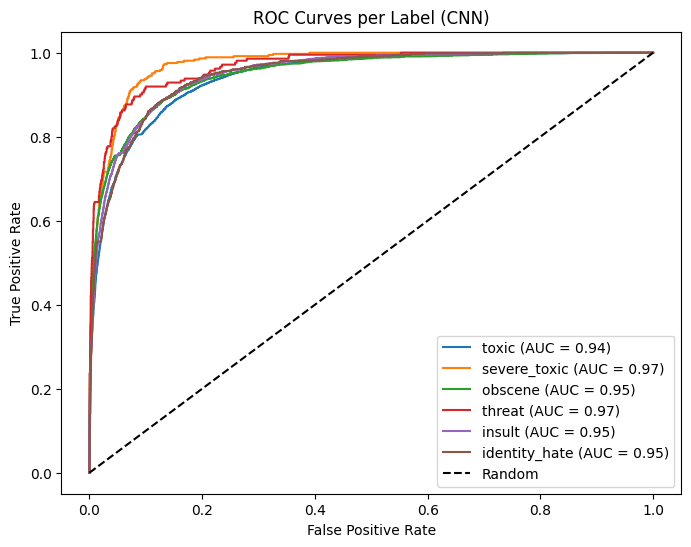

In [40]:
# Plotting ROC curves and Confusion Matrices for the CNN model's performance.

# A. ROC Curves
plt.figure(figsize=(8, 6))
for i, col in enumerate(label_cols):
    fpr, tpr, _ = sklearn.metrics.roc_curve(test_labels_cnn[:, i], test_preds_cnn[:, i])
    auc_score = sklearn.metrics.roc_auc_score(test_labels_cnn[:, i], test_preds_cnn[:, i])
    plt.plot(fpr, tpr, label=f'{col} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Label (CNN)')
plt.legend()
plt.show()

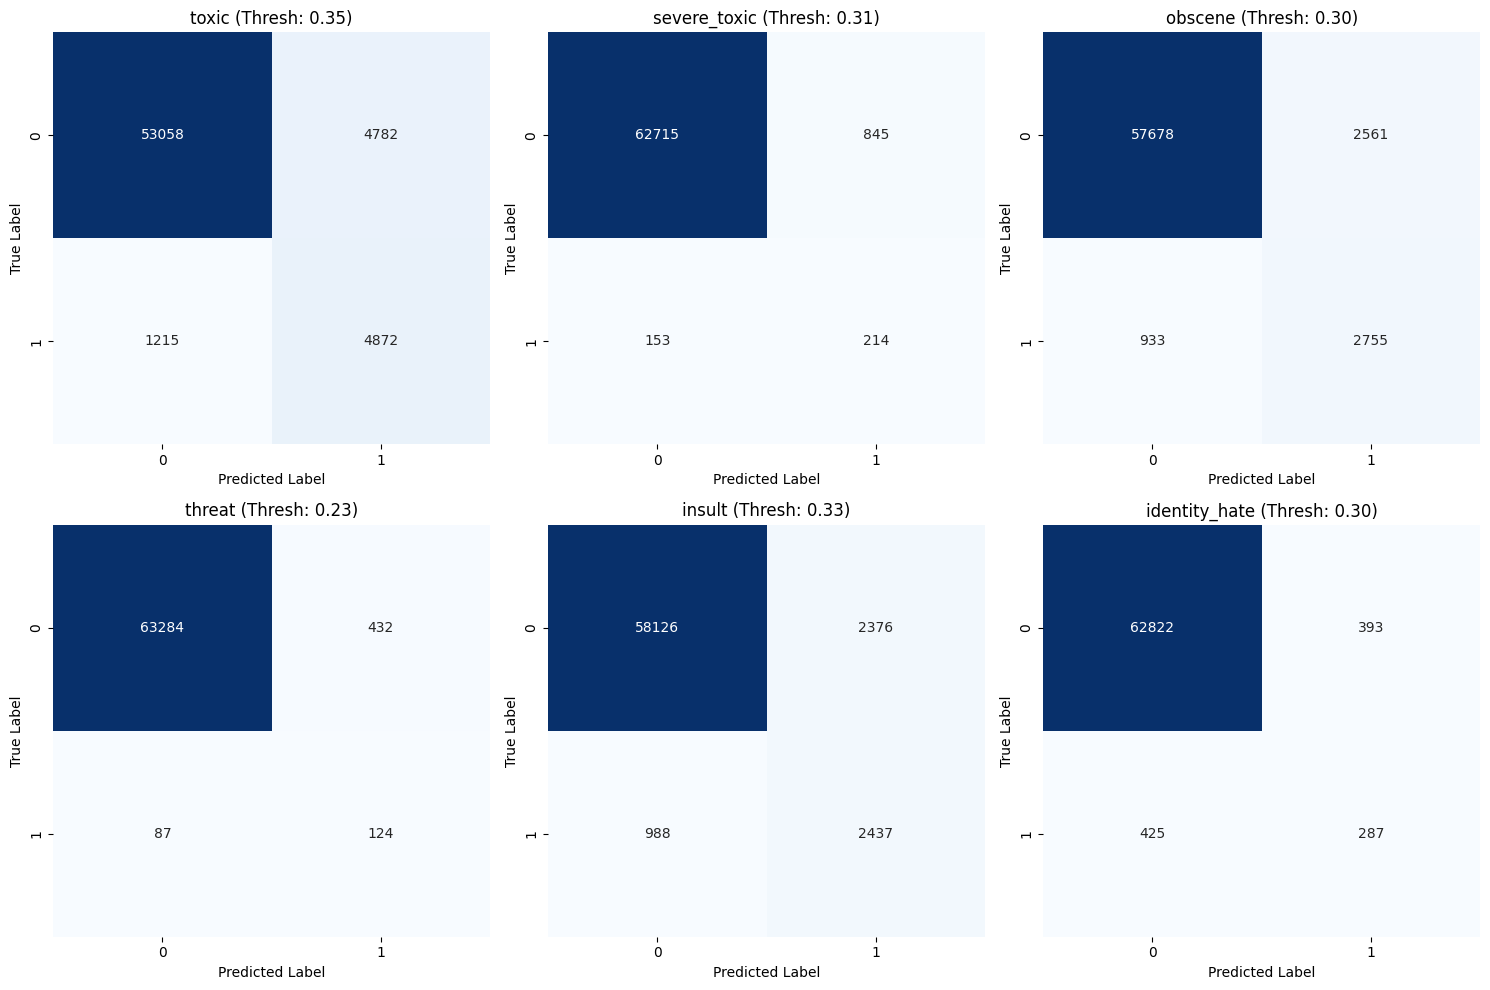

In [41]:
# B. Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(label_cols):
    cm = sklearn.metrics.confusion_matrix(test_labels_cnn[:, i], test_preds_binary_cnn[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar=False, 
                xticklabels=[0, 1], yticklabels=[0, 1])
    axes[i].set_title(f'{col} (Thresh: {best_thresholds_cnn[col]:.2f})')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

## Model 2: DistilBERT (Transformer-based Contextual Embedding)

### 8.Model 1 Data Preparation: DistilBERT Tokenization (Contextual Embedding)

#### 8.1 Tokenization and Encoding

In [42]:
# Define Hyperparameters specific to DistilBERT
MAX_LEN = 256 # Final verified Maximum token length
MODEL_NAME = 'distilbert-base-uncased'

# Load the DistilBERT tokenizer
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(
    train_texts.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN
)

val_encodings = tokenizer(
    val_texts.tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN
)

test_encodings = tokenizer(
    test_df_clean['comment_text_bert'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN
)

print(f"[INFO] Tokenization complete with MAX_LEN = {MAX_LEN}.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

[INFO] Tokenization complete with MAX_LEN = 256.


#### 8.2 Creating the PyTorch Dataset Class

In [43]:
class JigsawDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # Optimization: Convert all labels to float tensor once upon initialization
        self.labels = torch.tensor(labels, dtype=torch.float32) 

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve tokenized inputs and attention mask
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Retrieve the pre-converted float tensor label
        item['labels'] = self.labels[idx] 
        return item

#### 8.3 Generating PyTorch Dataset and DataLoader

In [44]:
from torch.utils.data import RandomSampler, SequentialSampler # Imports for Samplers
BATCH_SIZE = 32

# Create Dataset objects
train_dataset = JigsawDataset(train_encodings, train_y)
val_dataset = JigsawDataset(val_encodings, val_y)
test_dataset = JigsawDataset(test_encodings, test_df_clean[label_cols].values)

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset), # Equivalent to shuffle=True
    batch_size=BATCH_SIZE,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset), # Equivalent to shuffle=False
    batch_size=BATCH_SIZE,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset), # Sequential for prediction consistency
    batch_size=BATCH_SIZE,
    num_workers=2
)

print(f"[INFO] DataLoaders created with BATCH_SIZE = {BATCH_SIZE}.")
print(f"[INFO] Train batches: {len(train_dataloader)}")
print(f"[INFO] Validation batches: {len(val_dataloader)}")
print(f"[INFO] Test batches: {len(test_dataloader)}")

[INFO] DataLoaders created with BATCH_SIZE = 32.
[INFO] Train batches: 4482
[INFO] Validation batches: 498
[INFO] Test batches: 1998


### 9. Model 2 Architecture: DistilBertMultiLabel Definition

#### 9.1 Custom Model Definition and Optimizer Setup

In [45]:
from transformers import DistilBertModel
from transformers import get_linear_schedule_with_warmup
from torch import cuda, nn 
from torch.optim import AdamW

# 1. Define the custom multi-label classification model
class DistilBertMultiLabel(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.distilbert.config.dim, num_labels)
        self.loss_fn = FocalLoss(alpha=0.25, gamma=3) 

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(hidden_state)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return loss, torch.sigmoid(logits)

# 2. Initialize Model and Set Device
# Device check: GPU ache kina dekha
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

NUM_LABELS = 6 # (toxic, severe_toxic, obscene, threat, insult, identity_hate)
model = DistilBertMultiLabel(NUM_LABELS)

# Dual-GPU Setup (nn.DataParallel Speed Fix)
if torch.cuda.device_count() > 1:
    print(f"[INFO] Using {torch.cuda.device_count()} GPUs for Data Parallelism (Speed Fix).")
    model = nn.DataParallel(model) 
model.to(device)
print("[INFO] Model initialized and moved to device/DataParallel.")

[INFO] Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[INFO] Model initialized and moved to device/DataParallel.


### 10. Model 2 Training Functions and Execution

In [47]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
# ---- Hyperparameters ---- 
LEARNING_RATE = 2e-5 
EPOCHS = 3 
total_steps = len(train_dataloader) * EPOCHS 

# ---- Optimizer & Scheduler ---- 
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                            num_training_steps=total_steps)

#### 10.1 Validation Function

In [48]:
def validation_step(model, val_dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            loss, _ = model(input_ids, attention_mask, labels=labels)
            if isinstance(model, nn.DataParallel):
                loss = loss.mean()   
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

#### 10.2 Training Function

In [49]:
import torch.nn.functional as F
from tqdm import tqdm
def train_fn(model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs):
    # Best validation loss tracking
    best_val_loss = float('inf')
    model_save_path = 'best_model.pt'
    
    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1}/{epochs} ---")
        model.train()
        total_loss = 0
        
        # Using tqdm for progress bar
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            model.zero_grad()
            loss, _ = model(input_ids, attention_mask, labels=labels)
            
            # GPU SAFETY FIX: Loss average if using DataParallel (nn.DataParallel)
            if isinstance(model, nn.DataParallel):
                loss = loss.mean()
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            
            # Print loss every 100 steps for quick feedback
            if step % 100 == 0 and step != 0:
                 print(f"  Step {step}/{len(train_dataloader)} Loss: {total_loss / (step + 1):.4f}")

        # Calculate average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        print(f"\nAverage Training Loss: {avg_train_loss:.4f}")
        
        # Validation Step
        avg_val_loss = validation_step(model, val_dataloader, device)
        print(f"Average Validation Loss: {avg_val_loss:.4f}")

        # Model Saving based on Best Validation Loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save the model's state dictionary
            # GPU SAFETY FIX: DataParallel requires saving model.module.state_dict()
            if isinstance(model, nn.DataParallel):
                 torch.save(model.module.state_dict(), model_save_path)
            else:
                 torch.save(model.state_dict(), model_save_path)
            print(f"Model Saved: Validation Loss improved to {best_val_loss:.4f}")

# ---- Execution ----
train_fn(model, train_dataloader, val_dataloader, optimizer, scheduler, device, EPOCHS)


--- Epoch 1/3 ---


Training:   2%|▏         | 101/4482 [00:44<31:45,  2.30it/s]

  Step 100/4482 Loss: 0.0087


Training:   4%|▍         | 201/4482 [01:28<31:16,  2.28it/s]

  Step 200/4482 Loss: 0.0059


Training:   7%|▋         | 301/4482 [02:12<30:44,  2.27it/s]

  Step 300/4482 Loss: 0.0050


Training:   9%|▉         | 401/4482 [02:56<29:56,  2.27it/s]

  Step 400/4482 Loss: 0.0045


Training:  11%|█         | 501/4482 [03:40<29:13,  2.27it/s]

  Step 500/4482 Loss: 0.0041


Training:  13%|█▎        | 601/4482 [04:24<28:25,  2.28it/s]

  Step 600/4482 Loss: 0.0039


Training:  16%|█▌        | 701/4482 [05:08<27:41,  2.28it/s]

  Step 700/4482 Loss: 0.0037


Training:  18%|█▊        | 801/4482 [05:52<26:54,  2.28it/s]

  Step 800/4482 Loss: 0.0035


Training:  20%|██        | 901/4482 [06:36<26:16,  2.27it/s]

  Step 900/4482 Loss: 0.0034


Training:  22%|██▏       | 1001/4482 [07:20<25:32,  2.27it/s]

  Step 1000/4482 Loss: 0.0034


Training:  25%|██▍       | 1101/4482 [08:04<24:51,  2.27it/s]

  Step 1100/4482 Loss: 0.0033


Training:  27%|██▋       | 1201/4482 [08:48<24:01,  2.28it/s]

  Step 1200/4482 Loss: 0.0032


Training:  29%|██▉       | 1301/4482 [09:32<23:18,  2.27it/s]

  Step 1300/4482 Loss: 0.0032


Training:  31%|███▏      | 1401/4482 [10:16<22:40,  2.27it/s]

  Step 1400/4482 Loss: 0.0031


Training:  33%|███▎      | 1501/4482 [11:00<21:51,  2.27it/s]

  Step 1500/4482 Loss: 0.0030


Training:  36%|███▌      | 1601/4482 [11:44<21:10,  2.27it/s]

  Step 1600/4482 Loss: 0.0030


Training:  38%|███▊      | 1701/4482 [12:28<20:25,  2.27it/s]

  Step 1700/4482 Loss: 0.0029


Training:  40%|████      | 1801/4482 [13:12<19:42,  2.27it/s]

  Step 1800/4482 Loss: 0.0029


Training:  42%|████▏     | 1901/4482 [13:56<18:59,  2.27it/s]

  Step 1900/4482 Loss: 0.0029


Training:  45%|████▍     | 2001/4482 [14:40<18:15,  2.26it/s]

  Step 2000/4482 Loss: 0.0028


Training:  47%|████▋     | 2101/4482 [15:24<17:31,  2.26it/s]

  Step 2100/4482 Loss: 0.0028


Training:  49%|████▉     | 2201/4482 [16:08<16:43,  2.27it/s]

  Step 2200/4482 Loss: 0.0028


Training:  51%|█████▏    | 2301/4482 [16:52<16:01,  2.27it/s]

  Step 2300/4482 Loss: 0.0027


Training:  54%|█████▎    | 2401/4482 [17:37<15:15,  2.27it/s]

  Step 2400/4482 Loss: 0.0027


Training:  56%|█████▌    | 2501/4482 [18:21<14:33,  2.27it/s]

  Step 2500/4482 Loss: 0.0027


Training:  58%|█████▊    | 2601/4482 [19:05<13:50,  2.27it/s]

  Step 2600/4482 Loss: 0.0027


Training:  60%|██████    | 2701/4482 [19:49<13:04,  2.27it/s]

  Step 2700/4482 Loss: 0.0027


Training:  62%|██████▏   | 2801/4482 [20:33<12:20,  2.27it/s]

  Step 2800/4482 Loss: 0.0027


Training:  65%|██████▍   | 2901/4482 [21:17<11:35,  2.27it/s]

  Step 2900/4482 Loss: 0.0026


Training:  67%|██████▋   | 3001/4482 [22:01<10:50,  2.28it/s]

  Step 3000/4482 Loss: 0.0026


Training:  69%|██████▉   | 3101/4482 [22:45<10:08,  2.27it/s]

  Step 3100/4482 Loss: 0.0026


Training:  71%|███████▏  | 3201/4482 [23:29<09:23,  2.27it/s]

  Step 3200/4482 Loss: 0.0026


Training:  74%|███████▎  | 3301/4482 [24:13<08:39,  2.27it/s]

  Step 3300/4482 Loss: 0.0026


Training:  76%|███████▌  | 3401/4482 [24:57<07:57,  2.26it/s]

  Step 3400/4482 Loss: 0.0026


Training:  78%|███████▊  | 3501/4482 [25:41<07:12,  2.27it/s]

  Step 3500/4482 Loss: 0.0026


Training:  80%|████████  | 3601/4482 [26:25<06:28,  2.27it/s]

  Step 3600/4482 Loss: 0.0025


Training:  83%|████████▎ | 3701/4482 [27:09<05:44,  2.27it/s]

  Step 3700/4482 Loss: 0.0025


Training:  85%|████████▍ | 3801/4482 [27:53<04:59,  2.27it/s]

  Step 3800/4482 Loss: 0.0025


Training:  87%|████████▋ | 3901/4482 [28:37<04:16,  2.26it/s]

  Step 3900/4482 Loss: 0.0025


Training:  89%|████████▉ | 4001/4482 [29:21<03:31,  2.27it/s]

  Step 4000/4482 Loss: 0.0025


Training:  91%|█████████▏| 4101/4482 [30:05<02:47,  2.28it/s]

  Step 4100/4482 Loss: 0.0025


Training:  94%|█████████▎| 4201/4482 [30:49<02:03,  2.28it/s]

  Step 4200/4482 Loss: 0.0025


Training:  96%|█████████▌| 4301/4482 [31:34<01:19,  2.27it/s]

  Step 4300/4482 Loss: 0.0025


Training:  98%|█████████▊| 4401/4482 [32:18<00:35,  2.27it/s]

  Step 4400/4482 Loss: 0.0025


Training: 100%|██████████| 4482/4482 [32:53<00:00,  2.27it/s]


Average Training Loss: 0.0025


Average Validation Loss: 0.0021
Model Saved: Validation Loss improved to 0.0021

--- Epoch 2/3 ---


Training:   2%|▏         | 101/4482 [00:44<32:11,  2.27it/s]

  Step 100/4482 Loss: 0.0019


Training:   4%|▍         | 201/4482 [01:28<31:29,  2.27it/s]

  Step 200/4482 Loss: 0.0018


Training:   7%|▋         | 301/4482 [02:12<30:46,  2.26it/s]

  Step 300/4482 Loss: 0.0018


Training:   9%|▉         | 401/4482 [02:56<29:56,  2.27it/s]

  Step 400/4482 Loss: 0.0018


Training:  11%|█         | 501/4482 [03:40<29:12,  2.27it/s]

  Step 500/4482 Loss: 0.0018


Training:  13%|█▎        | 601/4482 [04:25<28:34,  2.26it/s]

  Step 600/4482 Loss: 0.0018


Training:  16%|█▌        | 701/4482 [05:09<27:48,  2.27it/s]

  Step 700/4482 Loss: 0.0018


Training:  18%|█▊        | 801/4482 [05:53<27:01,  2.27it/s]

  Step 800/4482 Loss: 0.0018


Training:  20%|██        | 901/4482 [06:37<26:17,  2.27it/s]

  Step 900/4482 Loss: 0.0018


Training:  22%|██▏       | 1001/4482 [07:21<25:39,  2.26it/s]

  Step 1000/4482 Loss: 0.0018


Training:  25%|██▍       | 1101/4482 [08:05<24:46,  2.27it/s]

  Step 1100/4482 Loss: 0.0018


Training:  27%|██▋       | 1201/4482 [08:49<24:10,  2.26it/s]

  Step 1200/4482 Loss: 0.0018


Training:  29%|██▉       | 1301/4482 [09:33<23:22,  2.27it/s]

  Step 1300/4482 Loss: 0.0018


Training:  31%|███▏      | 1401/4482 [10:17<22:41,  2.26it/s]

  Step 1400/4482 Loss: 0.0018


Training:  33%|███▎      | 1501/4482 [11:01<21:53,  2.27it/s]

  Step 1500/4482 Loss: 0.0018


Training:  36%|███▌      | 1601/4482 [11:45<21:03,  2.28it/s]

  Step 1600/4482 Loss: 0.0018


Training:  38%|███▊      | 1701/4482 [12:29<20:26,  2.27it/s]

  Step 1700/4482 Loss: 0.0018


Training:  40%|████      | 1801/4482 [13:13<19:38,  2.27it/s]

  Step 1800/4482 Loss: 0.0018


Training:  42%|████▏     | 1901/4482 [13:57<18:56,  2.27it/s]

  Step 1900/4482 Loss: 0.0018


Training:  45%|████▍     | 2001/4482 [14:41<18:12,  2.27it/s]

  Step 2000/4482 Loss: 0.0018


Training:  47%|████▋     | 2101/4482 [15:25<17:28,  2.27it/s]

  Step 2100/4482 Loss: 0.0018


Training:  49%|████▉     | 2201/4482 [16:09<16:46,  2.27it/s]

  Step 2200/4482 Loss: 0.0018


Training:  51%|█████▏    | 2301/4482 [16:53<16:03,  2.26it/s]

  Step 2300/4482 Loss: 0.0018


Training:  54%|█████▎    | 2401/4482 [17:38<15:16,  2.27it/s]

  Step 2400/4482 Loss: 0.0018


Training:  56%|█████▌    | 2501/4482 [18:22<14:32,  2.27it/s]

  Step 2500/4482 Loss: 0.0018


Training:  58%|█████▊    | 2601/4482 [19:06<13:47,  2.27it/s]

  Step 2600/4482 Loss: 0.0018


Training:  60%|██████    | 2701/4482 [19:50<13:04,  2.27it/s]

  Step 2700/4482 Loss: 0.0018


Training:  62%|██████▏   | 2801/4482 [20:34<12:17,  2.28it/s]

  Step 2800/4482 Loss: 0.0018


Training:  65%|██████▍   | 2901/4482 [21:18<11:38,  2.26it/s]

  Step 2900/4482 Loss: 0.0018


Training:  67%|██████▋   | 3001/4482 [22:02<10:51,  2.27it/s]

  Step 3000/4482 Loss: 0.0018


Training:  69%|██████▉   | 3101/4482 [22:46<10:09,  2.27it/s]

  Step 3100/4482 Loss: 0.0018


Training:  71%|███████▏  | 3201/4482 [23:30<09:23,  2.27it/s]

  Step 3200/4482 Loss: 0.0018


Training:  74%|███████▎  | 3301/4482 [24:14<08:40,  2.27it/s]

  Step 3300/4482 Loss: 0.0018


Training:  76%|███████▌  | 3401/4482 [24:58<07:55,  2.27it/s]

  Step 3400/4482 Loss: 0.0018


Training:  78%|███████▊  | 3501/4482 [25:42<07:12,  2.27it/s]

  Step 3500/4482 Loss: 0.0018


Training:  80%|████████  | 3601/4482 [26:26<06:28,  2.27it/s]

  Step 3600/4482 Loss: 0.0018


Training:  83%|████████▎ | 3701/4482 [27:10<05:43,  2.27it/s]

  Step 3700/4482 Loss: 0.0018


Training:  85%|████████▍ | 3801/4482 [27:54<04:59,  2.27it/s]

  Step 3800/4482 Loss: 0.0018


Training:  87%|████████▋ | 3901/4482 [28:38<04:15,  2.27it/s]

  Step 3900/4482 Loss: 0.0018


Training:  89%|████████▉ | 4001/4482 [29:22<03:31,  2.27it/s]

  Step 4000/4482 Loss: 0.0018


Training:  91%|█████████▏| 4101/4482 [30:07<02:47,  2.27it/s]

  Step 4100/4482 Loss: 0.0018


Training:  94%|█████████▎| 4201/4482 [30:51<02:04,  2.26it/s]

  Step 4200/4482 Loss: 0.0018


Training:  96%|█████████▌| 4301/4482 [31:35<01:20,  2.26it/s]

  Step 4300/4482 Loss: 0.0018


Training:  98%|█████████▊| 4401/4482 [32:19<00:35,  2.27it/s]

  Step 4400/4482 Loss: 0.0018


Training: 100%|██████████| 4482/4482 [32:54<00:00,  2.27it/s]


Average Training Loss: 0.0018


Average Validation Loss: 0.0020
Model Saved: Validation Loss improved to 0.0020

--- Epoch 3/3 ---


Training:   2%|▏         | 101/4482 [00:44<32:11,  2.27it/s]

  Step 100/4482 Loss: 0.0015


Training:   4%|▍         | 201/4482 [01:28<31:28,  2.27it/s]

  Step 200/4482 Loss: 0.0015


Training:   7%|▋         | 301/4482 [02:12<30:44,  2.27it/s]

  Step 300/4482 Loss: 0.0014


Training:   9%|▉         | 401/4482 [02:57<30:02,  2.26it/s]

  Step 400/4482 Loss: 0.0014


Training:  11%|█         | 501/4482 [03:41<29:11,  2.27it/s]

  Step 500/4482 Loss: 0.0014


Training:  13%|█▎        | 601/4482 [04:25<28:29,  2.27it/s]

  Step 600/4482 Loss: 0.0014


Training:  16%|█▌        | 701/4482 [05:09<27:49,  2.27it/s]

  Step 700/4482 Loss: 0.0015


Training:  18%|█▊        | 801/4482 [05:53<27:05,  2.27it/s]

  Step 800/4482 Loss: 0.0015


Training:  20%|██        | 901/4482 [06:37<26:25,  2.26it/s]

  Step 900/4482 Loss: 0.0015


Training:  22%|██▏       | 1001/4482 [07:21<25:30,  2.27it/s]

  Step 1000/4482 Loss: 0.0014


Training:  25%|██▍       | 1101/4482 [08:05<24:52,  2.27it/s]

  Step 1100/4482 Loss: 0.0014


Training:  27%|██▋       | 1201/4482 [08:49<24:04,  2.27it/s]

  Step 1200/4482 Loss: 0.0014


Training:  29%|██▉       | 1301/4482 [09:33<23:24,  2.26it/s]

  Step 1300/4482 Loss: 0.0014


Training:  31%|███▏      | 1401/4482 [10:17<22:38,  2.27it/s]

  Step 1400/4482 Loss: 0.0014


Training:  33%|███▎      | 1501/4482 [11:01<21:50,  2.27it/s]

  Step 1500/4482 Loss: 0.0014


Training:  36%|███▌      | 1601/4482 [11:45<21:12,  2.26it/s]

  Step 1600/4482 Loss: 0.0014


Training:  38%|███▊      | 1701/4482 [12:29<20:25,  2.27it/s]

  Step 1700/4482 Loss: 0.0014


Training:  40%|████      | 1801/4482 [13:13<19:43,  2.27it/s]

  Step 1800/4482 Loss: 0.0014


Training:  42%|████▏     | 1901/4482 [13:58<18:58,  2.27it/s]

  Step 1900/4482 Loss: 0.0014


Training:  45%|████▍     | 2001/4482 [14:42<18:14,  2.27it/s]

  Step 2000/4482 Loss: 0.0014


Training:  47%|████▋     | 2101/4482 [15:26<17:28,  2.27it/s]

  Step 2100/4482 Loss: 0.0014


Training:  49%|████▉     | 2201/4482 [16:10<16:46,  2.27it/s]

  Step 2200/4482 Loss: 0.0014


Training:  51%|█████▏    | 2301/4482 [16:54<15:59,  2.27it/s]

  Step 2300/4482 Loss: 0.0014


Training:  54%|█████▎    | 2401/4482 [17:38<15:17,  2.27it/s]

  Step 2400/4482 Loss: 0.0014


Training:  56%|█████▌    | 2501/4482 [18:22<14:31,  2.27it/s]

  Step 2500/4482 Loss: 0.0014


Training:  58%|█████▊    | 2601/4482 [19:06<13:48,  2.27it/s]

  Step 2600/4482 Loss: 0.0014


Training:  60%|██████    | 2701/4482 [19:50<13:03,  2.27it/s]

  Step 2700/4482 Loss: 0.0014


Training:  62%|██████▏   | 2801/4482 [20:34<12:20,  2.27it/s]

  Step 2800/4482 Loss: 0.0014


Training:  65%|██████▍   | 2901/4482 [21:18<11:36,  2.27it/s]

  Step 2900/4482 Loss: 0.0014


Training:  67%|██████▋   | 3001/4482 [22:02<10:52,  2.27it/s]

  Step 3000/4482 Loss: 0.0014


Training:  69%|██████▉   | 3101/4482 [22:46<10:09,  2.27it/s]

  Step 3100/4482 Loss: 0.0014


Training:  71%|███████▏  | 3201/4482 [23:30<09:23,  2.27it/s]

  Step 3200/4482 Loss: 0.0014


Training:  74%|███████▎  | 3301/4482 [24:14<08:41,  2.27it/s]

  Step 3300/4482 Loss: 0.0014


Training:  76%|███████▌  | 3401/4482 [24:58<07:55,  2.27it/s]

  Step 3400/4482 Loss: 0.0014


Training:  78%|███████▊  | 3501/4482 [25:42<07:11,  2.28it/s]

  Step 3500/4482 Loss: 0.0014


Training:  80%|████████  | 3601/4482 [26:27<06:27,  2.27it/s]

  Step 3600/4482 Loss: 0.0014


Training:  83%|████████▎ | 3701/4482 [27:11<05:44,  2.26it/s]

  Step 3700/4482 Loss: 0.0014


Training:  85%|████████▍ | 3801/4482 [27:55<04:59,  2.27it/s]

  Step 3800/4482 Loss: 0.0014


Training:  87%|████████▋ | 3901/4482 [28:39<04:16,  2.26it/s]

  Step 3900/4482 Loss: 0.0014


Training:  89%|████████▉ | 4001/4482 [29:23<03:32,  2.27it/s]

  Step 4000/4482 Loss: 0.0014


Training:  91%|█████████▏| 4101/4482 [30:07<02:47,  2.27it/s]

  Step 4100/4482 Loss: 0.0014


Training:  94%|█████████▎| 4201/4482 [30:51<02:03,  2.27it/s]

  Step 4200/4482 Loss: 0.0014


Training:  96%|█████████▌| 4301/4482 [31:35<01:19,  2.27it/s]

  Step 4300/4482 Loss: 0.0014


Training:  98%|█████████▊| 4401/4482 [32:19<00:35,  2.27it/s]

  Step 4400/4482 Loss: 0.0014


Training: 100%|██████████| 4482/4482 [32:55<00:00,  2.27it/s]


Average Training Loss: 0.0014


Average Validation Loss: 0.0021


### 11. Model 2 Evaluation and Visualizations

#### 11.1 Load Best Model


In [57]:
model_load_path = 'best_model.pt'
# Initialize the model structure
model_test = DistilBertMultiLabel(NUM_LABELS)
# Handle DataParallel state_dict keys if the model was trained on multiple GPUs
if torch.cuda.device_count() > 1:
    # Load state dict and map to the current device
    state_dict = torch.load(model_load_path, map_location=device)
    # Remove 'module.' prefix from keys caused by nn.DataParallel
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    model_test.load_state_dict(new_state_dict)

else:
    # Single GPU load is straightforward
    model_test.load_state_dict(torch.load(model_load_path, map_location=device))
model_test.to(device)
print(f"[INFO] Best model loaded from {model_load_path}.")

[INFO] Best model loaded from best_model.pt.


#### 11.2 Prediction Function

In [59]:
# Function to collect the model's output (probabilities) for all data in a DataLoader.
def get_predictions(model, loader):
    model.eval()
    all_preds = [] # Probability output
    all_labels = [] # True labels
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            _, preds = model(input_ids, attention_mask) # Sigmoid output
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)

#### 11.3 Threshold Optimization and Final Test Prediction

In [60]:
# Finding the optimal threshold for each label (based on max F1-score on the validation set) 
# to convert model probabilities into binary predictions (0 or 1).
val_preds, val_targets = get_predictions(model, val_dataloader)
best_thresholds = {}

print("\n--- Optimizing Thresholds (based on Validation F1-Score) ---")
for i, col in enumerate(label_cols):
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.01, 0.95, 0.01):
        hard_preds = (val_preds[:, i] >= thresh).astype(int)
        score = f1_score(val_targets[:, i], hard_preds, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_thresh = thresh
    best_thresholds[col] = best_thresh
    print(f"Label: {col:15} | Best Threshold: {best_thresh:.2f} | Best Val F1: {best_score:.4f}")

# Generate probability predictions on the final test set
test_preds_prob, test_targets = get_predictions(model, test_dataloader)

# Apply the best thresholds found from the validation set to create binary predictions
test_preds_binary = np.zeros_like(test_preds_prob)

for i, col in enumerate(label_cols):
    thresh = best_thresholds[col]
    test_preds_binary[:, i] = (test_preds_prob[:, i] >= thresh).astype(int)


--- Optimizing Thresholds (based on Validation F1-Score) ---
Label: toxic           | Best Threshold: 0.45 | Best Val F1: 0.8524
Label: severe_toxic    | Best Threshold: 0.39 | Best Val F1: 0.5489
Label: obscene         | Best Threshold: 0.46 | Best Val F1: 0.8481
Label: threat          | Best Threshold: 0.37 | Best Val F1: 0.6531
Label: insult          | Best Threshold: 0.43 | Best Val F1: 0.7801
Label: identity_hate   | Best Threshold: 0.44 | Best Val F1: 0.6259


#### 11.4 Final Performance Report

In [61]:
# Reporting the Macro Average ROC-AUC Score (primary competition metric) and a detailed classification report.
# ROC-AUC Score (Primary Competition Metric)
roc_auc = roc_auc_score(test_targets, test_preds_prob, average='macro')
print(f"\nMean ROC-AUC Score (Macro Average): {roc_auc:.4f}")

# Individual AUC Scores
auc_scores_ind = {col: roc_auc_score(test_targets[:, i], test_preds_prob[:, i]) for i, col in enumerate(label_cols)}
for col, score in auc_scores_ind.items():
    print(f"  {col:15}: {score:.4f}")

# Classification Report (using the optimized binary predictions)
print("\n--- Classification Report (using Optimized Thresholds) ---")
print(classification_report(test_targets, test_preds_binary, target_names=label_cols, zero_division=0))


Mean ROC-AUC Score (Macro Average): 0.9858
  toxic          : 0.9737
  severe_toxic   : 0.9901
  obscene        : 0.9814
  threat         : 0.9966
  insult         : 0.9810
  identity_hate  : 0.9918

--- Classification Report (using Optimized Thresholds) ---
               precision    recall  f1-score   support

        toxic       0.56      0.90      0.69      6087
 severe_toxic       0.31      0.66      0.42       367
      obscene       0.65      0.78      0.71      3688
       threat       0.47      0.70      0.56       211
       insult       0.66      0.75      0.70      3425
identity_hate       0.67      0.60      0.63       712

    micro avg       0.59      0.81      0.68     14490
    macro avg       0.55      0.73      0.62     14490
 weighted avg       0.60      0.81      0.68     14490
  samples avg       0.08      0.08      0.07     14490



#### 11.5 Visualizations (ROC Curves and Confusion Matrices)

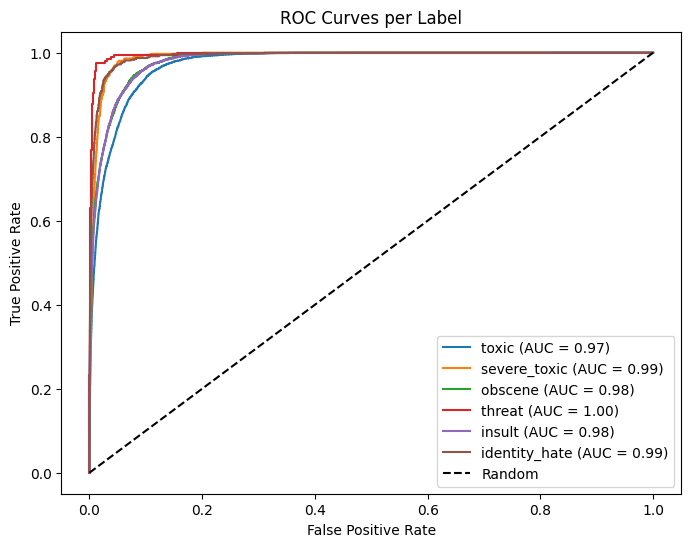

In [62]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve # <- roc_curve যোগ করা হলো
# Plotting the ROC (Receiver Operating Characteristic) curve for each label, which illustrates the trade-off 
# between the True Positive Rate (TPR) and the False Positive Rate (FPR).
plt.figure(figsize=(8, 6))
for i, col in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(test_targets[:, i], test_preds_prob[:, i])
    auc_score = roc_auc_score(test_targets[:, i], test_preds_prob[:, i])
    plt.plot(fpr, tpr, label=f'{col} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Label')
plt.legend()
plt.show()

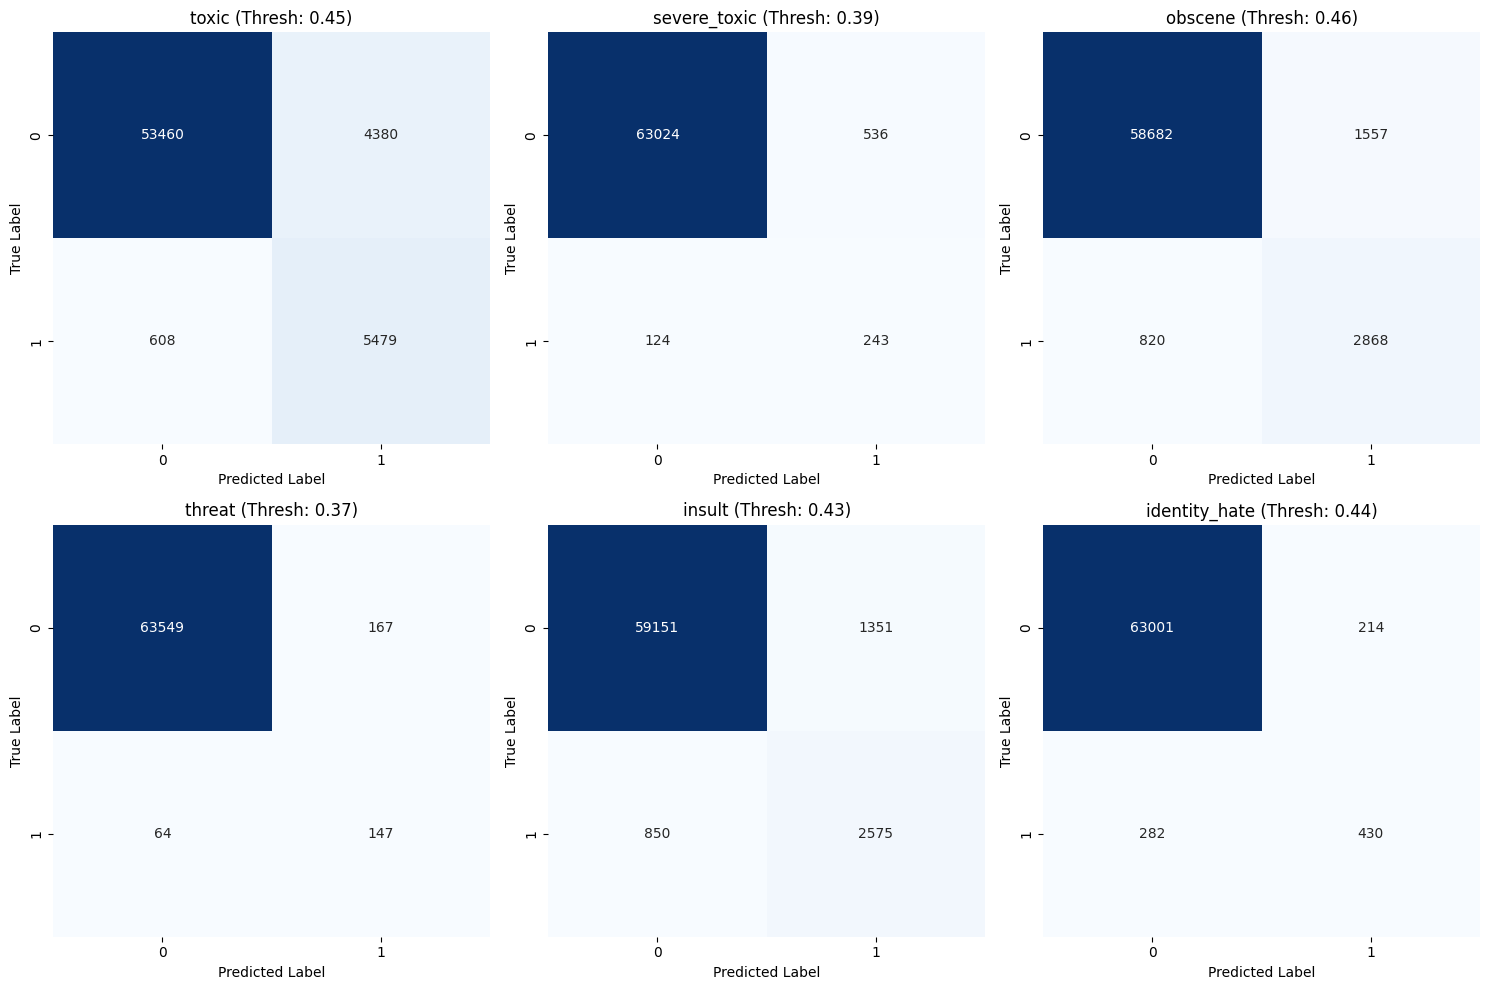

In [63]:
# Plotting confusion matrices for each label to detail the correctness and types of prediction errors.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(label_cols):
    cm = confusion_matrix(test_targets[:, i], test_preds_binary[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar=False, 
                xticklabels=[0, 1], yticklabels=[0, 1])
    axes[i].set_title(f'{col} (Thresh: {best_thresholds[col]:.2f})')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()